# Relating Age to Name

This notebook is inspired by [Nate Silver's](https://twitter.com/FiveThirtyEight) recent article on [How to Tell Someone's Age When All you Know is Her Name](http://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/). It allows one to (almost) replicate the analysis done in the article, and provides more extensive features. I have done similar work using R, and you can find it [here](https://github.com/ramnathv/agebyname).

## Data

We will uses four primary datasets.

1. [Babynames](http://www.ssa.gov/oact/babynames/names.zip)
2. [Babynames by State](http://www.ssa.gov/oact/babynames/state/namesbystate.zip)
3. [Cohort Life Tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html)
4. [Census Live Births Data](http://www.census.gov/statab/hist/02HS0013.xls)

We will download each of these datasets and process them to get them analysis ready.

In [1]:
%matplotlib inline
import re
import urllib
from zipfile import ZipFile
from os import path
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

### Baby Names

The first dataset we will be downloading is the [bnames](http://www.ssa.gov/oact/babynames/names.zip) dataset provided by SSA

In [4]:
#urllib.urlretrieve("http://www.ssa.gov/oact/babynames/names.zip", "names.zip")
zf = ZipFile("names.zip")
def read_names(f):
  data = pd.read_csv(zf.open(f), header = None, names = ['name', 'sex', 'n'])
  data['year'] = int(re.findall(r'\d+', f)[0])
  return data
  
bnames = pd.concat([read_names(f) for f in zf.namelist() if f.endswith('.txt')])
names_ =  set(bnames.name)
bnames.head()


,name,sex,n,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


### Baby Names by State

The second dataset we will be downloading is the [bnames_by_state](http://www.ssa.gov/oact/babynames/namesbystate.zip) dataset, also provided by SSA

In [5]:
#urllib.urlretrieve("http://www.ssa.gov/oact/babynames/state/namesbystate.zip", "namesbystate.zip")
zf = ZipFile("namesbystate.zip")
def read_names2(f):
  return pd.read_csv(zf.open(f), header = None, names = ['state', 'sex', 'year', 'name', 'n'])
  
bnames_by_state = pd.concat([read_names2(f) for f in zf.namelist() if f.endswith('.TXT')])
bnames_by_state.name.head()

0         Mary
1        Annie
2         Ruth
3        Ethel
4    Elizabeth
Name: name, dtype: object

### Cohort Life Tables

The next dataset is actuarial [cohort life tables](http://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html) provided by SSA. I was unable to figure out how to scrape this data using `BeautifulSoup`. So I used the R package `XML` to scrape these lifetables and saved it to [lifetables.csv](lifetables.csv). If you are interested in the R code, you can find it [here](https://github.com/ramnathv/agebyname/blob/master/rawdata/lifetables.R).

In [6]:
lifetables = pd.read_csv('lifetables.csv')
lifetables.head()

,x,qx,lx,dx,Lx,Tx,ex,sex,year
0,0,0.14596,100000,14596,90026,5151511,51.52,M,1900
1,1,0.03282,85404,2803,84003,5061484,59.26,M,1900
2,2,0.01634,82601,1350,81926,4977482,60.26,M,1900
3,3,0.01052,81251,855,80824,4895556,60.25,M,1900
4,4,0.00875,80397,703,80045,4814732,59.89,M,1900


You can read the documentation for the lifetables to understand the various parameters. The key column of interest to us is `lx`, which provides the number of people born in the year `year` who live upto the age `x`. Since we are in the year 2014, we are only interested in a subset of the data. 

In [7]:
lifetables_2014 = lifetables[lifetables['year'] + lifetables['x'] == 2014]
lifetables_2014.head()

,x,qx,lx,dx,Lx,Tx,ex,sex,year
114,114,0.76365,0,0,0,0,0.79,M,1900
234,114,0.75783,0,0,0,0,0.80,F,1900
344,104,0.46882,25,12,19,38,1.54,M,1910
464,104,0.42317,191,81,150,328,1.72,F,1910
574,94,0.26858,3122,838,2703,8656,2.77,M,1920


The cohort life tables are provided only for every decade. Since we need the data by year, we will use spline interpolation to fill out the gaps.

In [8]:
def process(d, kind = 'slinear'):
  f = interp1d(d.year, d.lx, kind)
  year = np.arange(1900, 2011)
  lx = f(year)
  return pd.DataFrame({"year": year, "lx": lx, "sex": d.sex.iloc[1]})

lifetable_2014 = lifetables_2014.\
  groupby('sex', as_index = False).\
  apply(process)
lifetable_2014.head()

lx sex  year
0 0   0.0   F  1900
  1  19.1   F  1901
  2  38.2   F  1902
  3  57.3   F  1903
  4  76.4   F  1904

### Census Live Births Data

Finally, we need [live births data](http://www.census.gov/statab/hist/02HS0013.xls) from the census to extrapolate the birth data to account for the correct that not all births were recorded by SSA till around 1930, since it wasn't mandatory.

In [9]:
#urllib.urlretrieve("http://www.census.gov/statab/hist/02HS0013.xls", "02HS0013.xls")
dat = pd.read_excel('02HS0013.xls', sheetname = 'HS-13', skiprows = range(14))
tot_births = dat.ix[9:101,:2].reset_index(drop = True)
tot_births.columns = ['year', 'births']
tot_births = tot_births.convert_objects(convert_numeric = True)
tot_births.head()

,year,births
0,1909,2718
1,1910,2777
2,1911,2809
3,1912,2840
4,1913,2869


We will now merge this data with the `bnames` aggregated by `year` to compute a set of correction factors, which will be used to scale the number of births. I have taken a very naive approach to do this, and there might be better ways to accomplish the same.

In [10]:
cor_factors = bnames.groupby('year', as_index = False).sum().merge(tot_births)
#print cor_factors
cor_factors['cor'] = cor_factors['births']*1000/cor_factors['n']
#print cor_factors
cor_factors = cor_factors[['year', 'cor']]
cor_factors.head()

,year,cor
0,1909,5.316621
1,1910,4.701051
2,1911,4.359994
3,1912,2.874354
4,1913,2.523141


We expand the correction factors data for the years 2002 to 2014 using the correction factor for the year 2001.

In [11]:
cor_new = pd.DataFrame({
  'year': range(2002, 2014),
  'cor': cor_factors.cor.iloc[-1]
})
cor_factors = pd.concat([cor_factors, cor_new])[['year', 'cor']]
cor_factors.head()

,year,cor
0,1909,5.316621
1,1910,4.701051
2,1911,4.359994
3,1912,2.874354
4,1913,2.523141


## Analysis

Now that we have all the required data, we need a few helper functions to help us with our analysis. The first function we will write is `get_data`, which takes `name`, `sex` and `state` and returns a data frame with the distribution of number of births and number of people alive by year.

In [12]:
"""def get_data(name, sex, state = None):
  if state is None:
    dat = bnames
  else:
    dat = bnames_by_state[(bnames_by_state["state"] == state)]
  data = dat[(dat['name'] == name) & (dat['sex'] == sex)].\
    merge(cor_factors).\
    merge(lifetable_2014)
  data['n_cor'] = data['n']*data['cor']
  data['n_alive'] = data['lx']/(10**5)*data['n_cor']
  return data
get_data('Violet', 'F').head()"""

'def get_data(name, sex, state = None):\n  if state is None:\n    dat = bnames\n  else:\n    dat = bnames_by_state[(bnames_by_state["state"] == state)]\n  data = dat[(dat[\'name\'] == name) & (dat[\'sex\'] == sex)].    merge(cor_factors).    merge(lifetable_2014)\n  data[\'n_cor\'] = data[\'n\']*data[\'cor\']\n  data[\'n_alive\'] = data[\'lx\']/(10**5)*data[\'n_cor\']\n  return data\nget_data(\'Violet\', \'F\').head()'

In [14]:
bname= bnames.set_index(['name'], inplace=True)

In [15]:
def get_data(name):
    dat = bnames
    dat = dat.loc[name]
    if type(dat) == pd.Series:
        m = pd.DataFrame(bnames.loc[name]).transpose()
    else:
        m = dat
    data =   m.\
            merge(cor_factors).\
            merge(lifetable_2014)
    data['n_cor'] = data['n']*data['cor']
    data['n_alive'] = data['lx']/(10**5)*data['n_cor']
    return data
get_data('The')  

,sex,n,year,cor,lx,n_cor,n_alive
0,M,5,1991,1.055731,97813.4,5.278654,5.163231


In [16]:
"""def get_data(name, state = None):
  if state is None:
    dat = bnames
  else:
    dat = bnames_by_state[(bnames_by_state["state"] == state)]
  data = dat.loc[name].\
    merge(cor_factors).\
    merge(lifetable_2014)
  data['n_cor'] = data['n']*data['cor']
  data['n_alive'] = data['lx']/(10**5)*data['n_cor']
  data['fraction'] = (data['n_alive']/data['n_alive'].sum())*100 #tell us the fraction of people named "name" who are 'n' years old.
  return data
get_data('Violet').head()"""

'def get_data(name, state = None):\n  if state is None:\n    dat = bnames\n  else:\n    dat = bnames_by_state[(bnames_by_state["state"] == state)]\n  data = dat.loc[name].    merge(cor_factors).    merge(lifetable_2014)\n  data[\'n_cor\'] = data[\'n\']*data[\'cor\']\n  data[\'n_alive\'] = data[\'lx\']/(10**5)*data[\'n_cor\']\n  data[\'fraction\'] = (data[\'n_alive\']/data[\'n_alive\'].sum())*100 #tell us the fraction of people named "name" who are \'n\' years old.\n  return data\nget_data(\'Violet\').head()'

In [31]:
from collections import defaultdict
import pickle

def age_brackets(name, gender=None):
    
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    if gender == 'male':
        gender = 'M'
    else:
        gender = 'F'

    dic = defaultdict(list)
    s=0
    s2=0
    s3=0
    s4=0
    f=0 
    f2=0
    f3=0
    f4=0
    s1=0
    f1=0

    #data.set_index(['name'])
    m = get_data(name).as_matrix()
    if len(m) != 0:
        for t in m:
            if t[2]>=1993:
                s = s+t[1]
                f = f + t[6]
                dic['B1'] = s,f
            elif t[2] >= 1983 and t[3]<=1992:
                s1 = s1+t[1]
                f1 = f1 + t[6]
                dic['B2'] = s1,f1
            elif t[2] >= 1973 and t[3]<=1982:
                s2 = s2+t[1]
                f2 = f2 + t[6]
                dic['B3'] = s2,f2
            elif t[2] >= 1963 and t[3]<=1972:
                s3 = s3+t[1]
                f3 = f3 + t[6]
                dic['B4'] = s3,f3
            elif t[2] <= 1962:
                s4 = s4+t[1]
                f4 = f4 + t[6]
                dic['B5'] = s4,f4
        #dic['B1'] = 0,0 fix pat file
    #print dic, '\n'
    
        d = pd.DataFrame(dic.values(),dic.keys(), columns=['n','n_alive'])
        d['fraction']= (d['n_alive']/d['n_alive'].sum())*100

    #return d
        pickle.dump(d, open( 'C:/Users/Elaine/Documents/GitHub/agebyname_py/name/' + name +'.pkl', 'wb'))

#d=age_brackets('Violet')

In [71]:
len(get_data('Mo').as_matrix())

0

In [107]:
get_data('Violet').as_matrix()

array([['F', 945L, 1909L, ..., 5024.206467968242, 8.636610918437407,
        0.01817865602541286],
       ['F', 1037L, 1910L, ..., 4874.989631279846, 9.311230195744507,
        0.019598619470112908],
       ['F', 1183L, 1911L, ..., 5157.872434875602, 55.921652938921284,
        0.11770595002479223],
       ..., 
       ['F', 2260L, 2009L, ..., 2432.628398791541, 2418.17615347432,
        5.089866027080335],
       ['F', 2564L, 2010L, ..., 2759.8492099564205, 2744.2008649359677,
        5.776094819996488],
       ['M', 5L, 2010L, ..., 5.381921236264471, 5.345647087132049,
        0.011251714422236075]], dtype=object)

In [19]:
tweets = pickle.load(open('C:\\Users\\Elaine\\Documents\\GitHub\\tweets.pkl', 'rb'))
print len(tweets)

992633


In [20]:
name = []

def first_name(name):
    if len(name) > 1:
        name = name.split()[0].lower().title()
    else:
        name = name.lower().title()
    #print name
    return name
    

In [21]:
for t in tweets:
   # if t['gender'] != 'unknown':
        name.append(first_name(t['real_name']))
            
print len(set(name))

178814


In [ ]:
i=0
gone = set()

for t in tweets:
    n=first_name(t['real_name'])
    print n        
    if n in set(names_) and n not in gone:
        gone.add(n)
        #print n
        age_brackets(t['real_name'])
        i = i+1
        #print i

Brentt
Steven
Compra
Tyler
Mariano
Dolphin
Stephanie
Joy
Jae
Ashleyy
Cat
Michael
Alexis
Sex
Kassidy
Damaged,
Kelsey�??Wasnesky
Erin
Wi�?�?
I
Ev
Jay
Jas.
Ayana
Patricio
Lewisville
�?�
Ramona
Mc
Chris
Masterscraft
Broly
Masterscraft
Masterscraft
Masterscraft
Tanchelle
James
Kristi
Mario
Aaron
7Th
Jenn
Austin
Hillaryyyy
Conception
Diana
Morris
Sex
Richard
Lisa
Justin
Alexxa.
Juicy
Elan
Clay
://Mz.Roe
Alex
????
Richard
Elchati
Whiteh03
Ganjababemandy?
Soc
Elan
Livingcannabis
C
Red
Janette
Ken
Dennis
William
Jonathan
Nicole
The
Arianna
William
V.V.
Zisman.
Zebra
David
Zebra
Zebra
Travis
Aleph-Null
Frank
Kel'C
Gail
Lewisville
Lewisville
Elan
Kristianized
Ataca
Vincent
Lucinda
Jennifer
Cassy
Jennifer
Mistymountain
Simple_Minded
Brent
Sirhellsing420
Justme&&You(:
Alicia
Oliver
Grace
?Lukastro�
Prosfores-Deals.Gr
Santiago
Russell
Karmah
Ted
Lewisville
Eugene
Lee
Canuckclicks
Darrian
Jared
?T-Deckah!
�?�Eat
Danny
Anthony
Fuzzy
Pappa
Ejo
Rodgy
Ig:
Storm
Mgt
Serch
Pandora
Drewby
Markelaskeeper
*Ca

In [ ]:
age_brackets('Mo')


In [33]:
# Tweets by month.
import matplotlib.pyplot as plt
import datetime
%pylab inline
def parse_date(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
positive_tweets = [t for t in tweets]

In [35]:
import glob, os

def data_gender(b,m,y,pos):
   
    DIR = 'C:/Users/Elaine/Documents/GitHub/agebyname_py/names/'
    os.chdir("C:/Users/Elaine/Documents/GitHub/agebyname_py/names/")
    gone = []
    summ = 0
    aa1 = 0
    count = 0
    
    for p in pos:
        if parse_date(p['posted_time']).month == m and parse_date(p['posted_time']).year == y:
            name = first_name(p['real_name'])
            if p['gender'] != 'unknown' and name not in gone:  
                gone.append(name)
                file_ = pickle.load(open(DIR+name+'.pkl'))
                aa = file_.to_dict()

                aa1 += aa['fraction'][b]
                count +=1       
    return aa1/count, (m,y)

In [36]:
data = []    
for m in range(1,10):
    data.append(('B1',data_gender('B1', m, 2013, positive_tweets)))
    data.append(('B2',data_gender('B2', m, 2013, positive_tweets)))
    data.append(('B3',data_gender('B3', m, 2013, positive_tweets)))
    data.append(('B4',data_gender('B4', m, 2013, positive_tweets)))
    data.append(('B5',data_gender('B5', m, 2013, positive_tweets)))   

for m in range(10,13):
    data.append(('B1',data_gender('B1', m, 2012, positive_tweets)))
    data.append(('B2',data_gender('B2', m, 2012, positive_tweets)))
    data.append(('B3',data_gender('B3', m, 2012, positive_tweets)))
    data.append(('B4',data_gender('B4', m, 2012, positive_tweets)))
    data.append(('B5',data_gender('B5', m, 2012, positive_tweets)))

In [37]:
sorted(data, key=lambda x: x[1])

[('B2', (6.8085454562096004, (3, 2013))),
 ('B2', (6.8633070691709523, (9, 2013))),
 ('B2', (6.8854616125696602, (8, 2013))),
 ('B2', (6.8986797705198528, (4, 2013))),
 ('B2', (6.9008585031130032, (7, 2013))),
 ('B2', (6.9306738118842226, (5, 2013))),
 ('B2', (6.9467529184421268, (6, 2013))),
 ('B2', (6.9469881419372017, (2, 2013))),
 ('B2', (7.0295680757758738, (1, 2013))),
 ('B2', (7.0905087554451915, (12, 2012))),
 ('B2', (7.2046547509274053, (11, 2012))),
 ('B2', (7.357461307061838, (10, 2012))),
 ('B3', (12.702634220498496, (3, 2013))),
 ('B4', (12.746206630938529, (3, 2013))),
 ('B3', (12.788237937055829, (4, 2013))),
 ('B3', (12.793521990171028, (9, 2013))),
 ('B3', (12.813307055508918, (7, 2013))),
 ('B3', (12.815633181638976, (8, 2013))),
 ('B3', (12.819091878880535, (6, 2013))),
 ('B4', (12.843766284467439, (7, 2013))),
 ('B4', (12.858240428756279, (9, 2013))),
 ('B3', (12.888581141317299, (2, 2013))),
 ('B4', (12.907505814727553, (4, 2013))),
 ('B4', (12.929455717469411, (6,

In [38]:
B1 = []
B2 = []
B3 = []
B4 = []
B5 = []

for d in sorted(data, key=lambda x: x[1][1][1]):
    #print d[1][0]
    #break
    if d[0] == 'B1':
        B1.append(d[1][0])
    elif d[0] == 'B2':
        B2.append(d[1][0])
    elif d[0] == 'B3':
        B3.append(d[1][0])
    elif d[0] == 'B4':
        B4.append(d[1][0])
    elif d[0] == 'B5':
        B5.append(d[1][0])

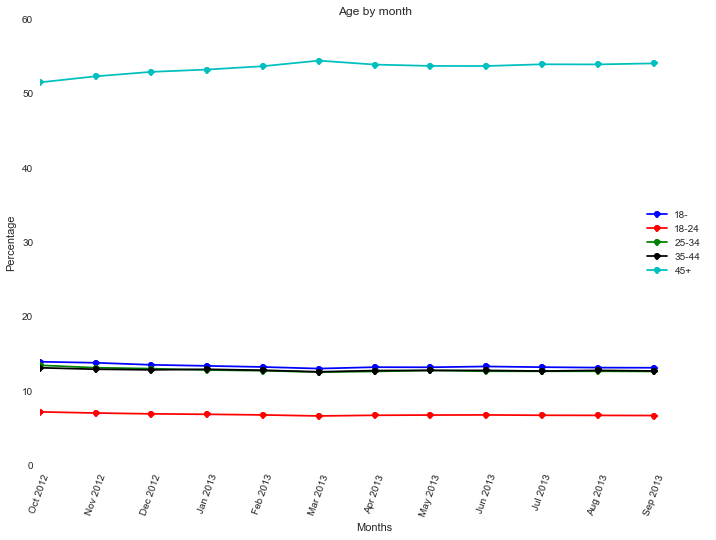

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
a, = plt.plot(B1,'bo-')
b, = plt.plot(B2,'ro-')
c, = plt.plot(B3,'go-')
d, = plt.plot(B4,'ko-')
e, = plt.plot(B5,'co-')
plt.xlabel('Months')
plt.ylabel('Percentage')
plt.title('Age by month')
plt.xticks(rotation=70) 
plt.xticks(range(12),['Oct 2012','Nov 2012','Dec 2012','Jan 2013','Feb 2013','Mar 2013','Apr 2013','May 2013','Jun 2013','Jul 2013','Aug 2013','Sep 2013'])
plt.legend([a,b,c,d,e], ["18-",'18-24','25-34','35-44','45+'], loc=0)

Our next helper function is `plot_name` which accepts the same arguments as `get_data`, but returns a plot of the distribution of number of births and number alive by year.

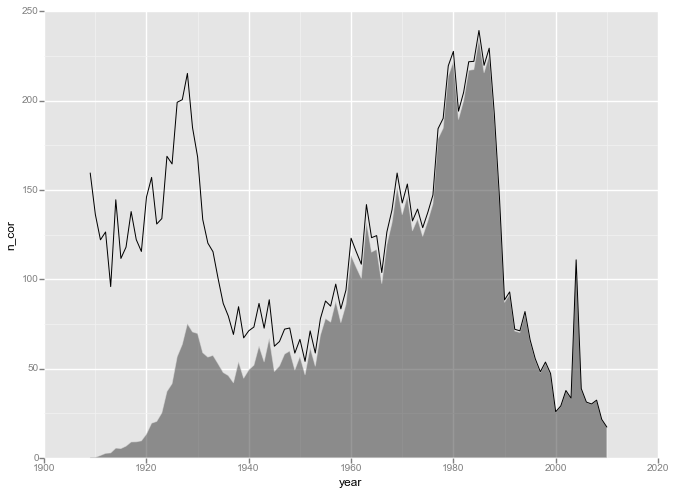

<ggplot: (28553294)>

In [16]:
def plot_name(name, sex, state = None):
  data = get_data(name, sex, state)
  return ggplot(data, aes('year', 'n_cor')) +\
    geom_line() +\
    geom_area(aes(ymin = 0, ymax = 'n_alive'), alpha = 0.5)
plot_name("Joseph", "F")

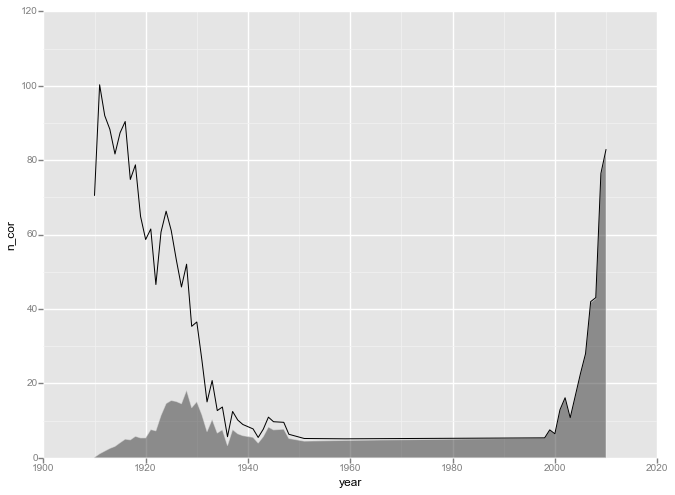

<ggplot: (28553378)>

In [17]:
plot_name("Violet", "F", "MA")

### Estimate Age

We will now write a function that will help us figure out the probability that a person with a certain name is alive, as well as the quantiles of their age distribution. Since we are dealing with weighted data, I will use some code copied from the [wquantiles](https://github.com/nudomarinero/wquantiles/) module. The `quantile` function accepts a data array and a weights array to return a specific quantile

In [18]:
# from the module wquantiles https://github.com/nudomarinero/wquantiles/blob/master/weighted.py
import numpy as np
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix) :
        data = np.asarray(data)
    if not isinstance(weights, np.matrix) :
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    Pn = (Sn-0.5*sorted_weights)/np.sum(sorted_weights)
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def quantile(data, weights, quantile):
    """
    Weighted quantile of an array with respect to the last axis.

    Parameters
    ----------
    data : ndarray
        Input array.
    weights : ndarray
        Array with the weights. It must have the same size of the last 
        axis of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile : float
        The output value.
    """
    # TODO: Allow to specify the axis
    nd = data.ndim
    if nd == 0:
        TypeError("data must have at least one dimension")
    elif nd == 1:
        return quantile_1D(data, weights, quantile)
    elif nd > 1:
        n = data.shape
        imr = data.reshape((np.prod(n[:-1]), n[-1]))
        result = np.apply_along_axis(quantile_1D, -1, imr, weights, quantile)
        return result.reshape(n[:-1])

We will use the `quantile` function to write an `estimate_age` function that will return the living probabilities and quantiles for a given `name`, `sex` and `state`.

In [58]:
def estimate_age(name, sex, state = None):
  data = get_data(name, sex, state)
  print data
  qs = [1, 0.75, 0.5, 0.25, 0]
  quantiles = [2014 - int(quantile(data.year, data.n_alive, q)) for q in qs]
  print 'Quantiles \n', quantiles  
  result = dict(zip(['q0', 'q25', 'q50', 'q75', 'q100'], quantiles))
  result['p_alive'] = round(data.n_alive.sum()/data.n_cor.sum()*100, 2)
  result['sex'] = sex
  result['name'] = name
  return pd.Series(result)
  
estimate_age('Gertrude', 'F')

         name sex     n  year       cor       lx         n_cor      n_alive
0    Gertrude   F  2622  1909  5.316621    171.9  13940.179216    23.963168
1    Gertrude   F  2932  1910  4.701051    191.0  13783.480809    26.326448
2    Gertrude   F  2895  1911  4.359994   1084.2  12622.181487   136.849692
3    Gertrude   F  3887  1912  2.874354   1977.4  11172.615096   220.927291
4    Gertrude   F  4015  1913  2.523141   2870.6  10130.409164   290.803525
5    Gertrude   F  4937  1914  2.094174   3763.8  10338.938509   389.136968
6    Gertrude   F  6077  1915  1.618028   4657.0   9832.759156   457.911594
7    Gertrude   F  6243  1916  1.532241   5550.2   9565.778305   530.919827
8    Gertrude   F  6300  1917  1.467019   6443.4   9242.218049   595.513078
9    Gertrude   F  6264  1918  1.357785   7336.6   8505.162160   623.989727
10   Gertrude   F  6015  1919  1.298397   8229.8   7809.859669   642.735831
11   Gertrude   F  5797  1920  1.303726   9123.0   7557.697594   689.488751
12   Gertrud

name       Gertrude
p_alive       18.17
q0                4
q100            105
q25              71
q50              82
q75              90
sex               F
dtype: object

In [20]:
estimate_age('Ava', 'F')

name         Ava
p_alive    95.24
q0             4
q100         105
q25            6
q50            8
q75           10
sex            F
dtype: object

We can now use the `estimate_age` function to compute the quantiles for the most common names and replicate the plots in the Nate Silver article.

In [21]:
top_100_names = bnames.\
  groupby(['name', 'sex'], as_index = False).\
  sum().\
  sort('n', ascending = False)
top_25_females = top_100_names[(top_100_names["sex"] == "F")]
estimates = pd.concat([estimate_age(name, 'F') for name in top_25_females["name"].iloc[:25].tolist()], axis = 1)
estimates.T.sort('q50').reset_index()

,index,name,p_alive,q0,q100,q25,q50,q75,sex
0,23,Emily,90.62,4,105,12,19,28,F
1,18,Ashley,98.5,4,97,18,24,28,F
2,10,Jessica,97.9,4,105,22,27,32,F
3,9,Sarah,83.63,4,105,19,28,37,F
4,16,Anna,51.81,4,105,17,34,65,F
5,3,Jennifer,96.63,4,98,29,36,42,F
6,1,Elizabeth,70.05,4,105,23,39,58,F
7,24,Michelle,95.92,4,99,29,40,47,F
8,20,Kimberly,95.87,4,81,30,41,48,F
9,15,Lisa,94.48,4,104,40,47,51,F


We can go a step beyond the article and also use the `state` parameter to get more specific quantiles, if we know the place of birth of a person.

The final step for me is to convert all of this into an interactive webapp. I have done it with R using the [shiny](http://rstudio.com/shiny) package. I am still getting the hang of web frameworks in python, so it will be a while before I get to doing this.

In [23]:
estimate_age('Austin','M')

name       Austin
p_alive      94.8
q0              4
q100          105
q25            13
q50            17
q75            21
sex             M
dtype: object